**Dogs vs Cats Classifier**\
I am trying to build a model that can differentiate between a ***dog***,***cat***, and also ***unindentified*** object

In [ ]:
# using fastbook
# ! [ -e /content ] && pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.4 MB/s 
     |████████████████████████████████| 197 kB 46.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.0 MB/s 
     |████████████████████████████████| 59 kB 5.9 MB/s 
Mounted at /content/gdrive


In [ ]:
# import all libraries -- not a good a way but it should work for now
# from fastbook import *
# from fastai.vision.widgets import *

In [ ]:
# connect to the AZURE key
key = os.environ.get('AZURE_SEARCH_KEY', 'cd9885bcf25c4585956668a4e247e37d')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
# search for an image
results = search_images_bing(key, 'cats')
ims = results.attrgot('contentUrl')
ims
print('Images length: ', len(ims))

Images length:  150


In [ ]:
# download an image
dest = 'images/cats.jpg'
download_url(ims[0], dest)

Path('images/cats.jpg')

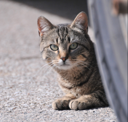

In [ ]:
# view an image
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
# form list of images to use and create a place to store it
entities = ['cats', 'dogs', 'human face']
path = Path('entities')

In [ ]:
# make a directory to store all images
if not path.exists():
    path.mkdir()
    for e in entities:
        dest = (path/e)
        dest.mkdir(exist_ok=True) 
        results = search_images_bing(key, f'{e} entity')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# get image files
fns = get_image_files(path)
fns

(#408) [Path('entities/cats/00000060.jpg'),Path('entities/cats/00000137.jpeg'),Path('entities/cats/00000015.png'),Path('entities/cats/00000146.jpg'),Path('entities/cats/00000108.jpg'),Path('entities/cats/00000085.jpg'),Path('entities/cats/00000095.jpg'),Path('entities/cats/00000076.jpg'),Path('entities/cats/00000144.jpg'),Path('entities/cats/00000105.png')...]

In [ ]:
# check for broken images
failed = verify_images(fns)
print('Failed images: ', failed)
print('Failed images length: ', len(failed))

Failed images:  [Path('entities/cats/00000060.jpg'), Path('entities/cats/00000105.png'), Path('entities/cats/00000147.gif'), Path('entities/cats/00000006.jpg'), Path('entities/cats/00000109.jpg'), Path('entities/cats/00000091.jpg'), Path('entities/cats/00000115.jpg'), Path('entities/human face/00000015.png'), Path('entities/human face/00000021.png'), Path('entities/human face/00000131.jpg'), Path('entities/human face/00000011.jpg'), Path('entities/human face/00000115.jpg'), Path('entities/human face/00000136.jpg'), Path('entities/dogs/00000029.jpg')]
Failed images length:  14


In [ ]:
# remove the broken images
failed.map(Path.unlink);

In [ ]:
# join each image and its label in a block
entities = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
entities

In [ ]:
# we need to load our datablock
dls = entities.dataloaders(path)

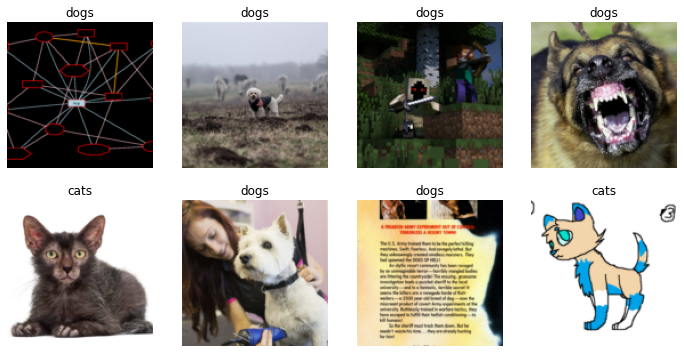

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

In [ ]:
entities = entities.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = entities.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.836620,1.663372,0.603175,00:13


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.287070,0.882580,0.349206,00:13
1,1.094953,0.697792,0.269841,00:13
2,0.898139,0.713970,0.253968,00:14
3,0.767580,0.705232,0.206349,00:14


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


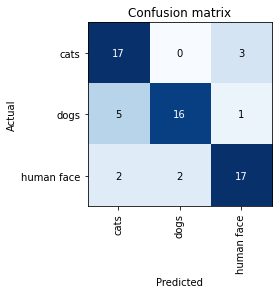

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

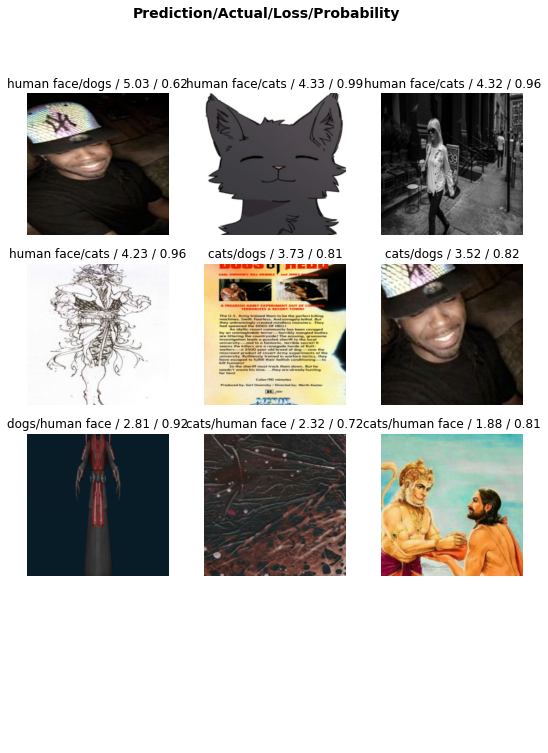

In [ ]:
interp.plot_top_losses(12, nrows=4)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,path_to_move in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/path_to_move)

In [ ]:
# export the model
learn.export()

In [ ]:
# check if the model has been created
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Let's now test our model

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
pth = Path('images')
dl = pth.ls()
for image in dl:
  if not image.name == '.ipynb_checkpoints': 
    print('Image Name: ', image.name, ' Prediction: ', learn_inf.predict(image))
# learn_inf.predict('images/dp_pic.jpg')

Image Name:  girl_face.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([0.0896, 0.0151, 0.8953]))


Image Name:  cats.jpg  Prediction:  ('cats', TensorBase(0), TensorBase([9.9979e-01, 1.1596e-04, 9.6229e-05]))


Image Name:  many_matured_faces.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([0.0217, 0.0052, 0.9731]))


Image Name:  neymarr.png  Prediction:  ('human face', TensorBase(2), TensorBase([0.1610, 0.0030, 0.8359]))


Image Name:  puppies_draw.png  Prediction:  ('cats', TensorBase(0), TensorBase([0.9454, 0.0509, 0.0038]))


Image Name:  pup.jpg  Prediction:  ('dogs', TensorBase(1), TensorBase([2.5010e-02, 9.7440e-01, 5.9307e-04]))


Image Name:  weird_cat_drawing.png  Prediction:  ('human face', TensorBase(2), TensorBase([0.0511, 0.0172, 0.9317]))


Image Name:  many_dogs.jpeg  Prediction:  ('dogs', TensorBase(1), TensorBase([2.9027e-02, 9.7092e-01, 5.0734e-05]))


Image Name:  cat_cartoon.png  Prediction:  ('cats', TensorBase(0), TensorBase([0.9685, 0.0158, 0.0157]))


Image Name:  cartoon_faces.jpg  Prediction:  ('human face', TensorBase(2), TensorBase([0.0644, 0.0540, 0.8816]))


In [ ]:
# categories
learn_inf.dls.vocab

['cats', 'dogs', 'human face']

In [ ]:
# create upload button
btn_upload = widgets.FileUpload()
# btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
# simulate the upload process
# btn_upload = SimpleNamespace(data = ['images/many_dogs.jpeg'])

In [ ]:
# get the uploaded data
img = PILImage.create(btn_upload.data[-1])

In [ ]:
# display the image in a thumbnail format
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
# out_pl

Output()

In [ ]:
# get model inference props
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
# prediction result
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
# lbl_pred

Label(value='Prediction: dogs; Probability: 0.9709')

In [ ]:
# create a button to classify the image
btn_run = widgets.Button(description='Classify')
# btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
# create the button handler
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your image: '), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
  # !pip install voila
  # !jupyter serverextension enable --sys-prefix voila